## Distance Metrics

앞서 경험적 상관계수 행렬의 중요한 수치적 특성을 연구했다. 그 모든 장점에도 불구하고, 상관계수는 상호의존성의 척도로서 몇 가지 결정적인 한계에 시달린다.
이번 절에서는 인터넷, 휴대 전화, 파일 압축, 비디오 스트리밍, 암호화 등 많은 현대의 경이로움이 바탕에 있는 정보 이론 개념을 검토해 그러한 한계를 극복한다.
만약 연구자들이 상호 의존성을 이해하고자 상관계수를 넘어서 보지 않았다면 이 발명들 중 어떤 것도 가능하지 않았을 것이다.

밝혀진 바와 같이 일반적으로 정보 이론, 특히 Shannon Entropy개념은 금융에 있어서 유용한 응용 분야를 가지고 있다. 엔트로피의 핵심 아이디어는 랜덤 변수와 관련된 불확실성의 양을 계량화하는 것이다.
많은 머신러닝 알고리즘의 1차 목표는 문제 해결과 관련된 불확실성의 양을 줄이는 것이기 때문에, 정보 이론은 머신러닝에 필수적이다.
이번 장에서는 다음과 같은 것들을 다룬다

1. Dicision Tree 모델 학습의 목적 함수 정의
2. 분류 문제에 대한 손실 함수 정의
3. 두 랜덤 변수 사이의 거리 평가
4. 군집 비교
5. 특성 선택

위와 같은 다양한 환경에서 머신러닝 전체에 사용되는 개념을 검토하도록 한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings

warnings.filterwarnings('ignore')

TICKERS = pd.read_excel('S&P500_ticker_list.xlsx')['Symbol'].tolist()
START_DATE = '2010-01-01'
END_DATE = pd.to_datetime('today')

data = yf.download(
    TICKERS,
    start = START_DATE,
    end = END_DATE,
    progress = True
)['Close']

[*********************100%%**********************]  503 of 503 completed


In [2]:
data = data.resample('W').last().dropna(axis = 1)
ret = data.pct_change().dropna()

### Correlation based Distance

상관계수는 선형적 상호의존성의 유용한 척도다. 일단 상관계수 행렬의 잡음과 주음이 제거되면 시스템에 대한 중요한 구조 정보를 보일 수 있다. 예를 들어서, 상호 연관성이 매우 높은 유가증권의 군집을 식별하고자 상관계수를 사용할 수 있다. 그러나 상관계수를 사용하기 전에 기술적 문제를 해결해야 한다. 상관계수는 비음성과 삼각 부등식 조건을 충족시키지 못하기 때문에 척도가 되지 못한다. 거리 척도는 집합에 대한 직관적인 위상관계를 유도하기 때문에 중요하다. 이러한 직관적 위상관계 없이 상호 의존성의 비거리적 측정을 비교하는 것은 다소 일관성 없는 결과를 초래할 수 있다. 예를 들어서 상관계수 (0.9, 1.0)의 차이는 (0.1, 0.2)의 차이와 같다. 물론 전자가 상호의존성의 관점에서 더 큰 차이를 가질 것이다.

크기 $T$의 랜덤 벡터 $X$와 $Y$와 상관계수 추정치 $\rho[X,Y]$를 고려하자. 상관계수는 단지 $\sigma_{X,Y} = \rho(X, Y)\sigma_X\sigma_Y$를 만족하면 되는데 여기서 $\sigma_{X,Y}$는 두 벡터의 공분산이고, $\sigma$는 표준 편차다. pearson correlation은 이들 조건을 만족하는 여러 상관계수 추정치 중 하나다. 이때, $d_\rho(X,Y) = \sqrt{\frac{1}{2(1 - \rho(X, Y))}}$는 거리 척도다.

In [3]:
from FinancialMachineLearning.metrics.distance import corr_based_distance

dist = corr_based_distance(ret)

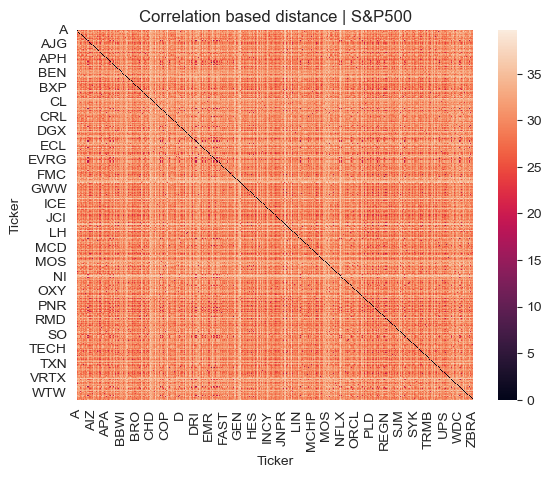

In [4]:
sns.heatmap(dist, annot = False)
plt.title('Correlation based distance | S&P500')
plt.show()

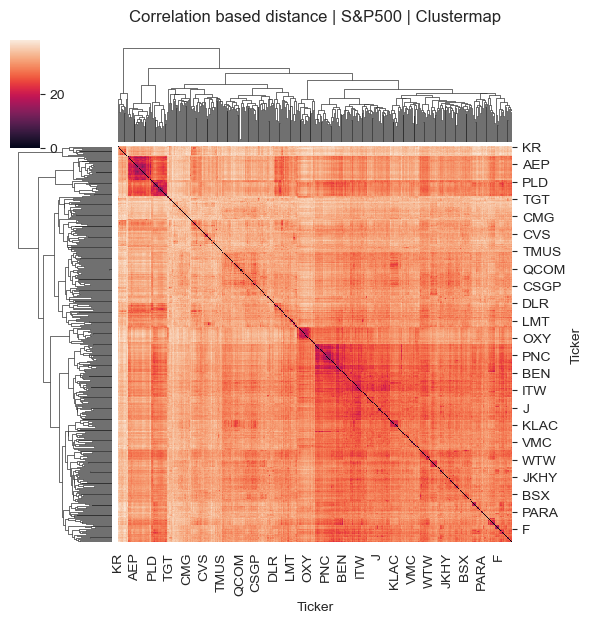

In [5]:
clustermap = sns.clustermap(dist, annot = False, figsize = (6, 6))
clustermap.ax_heatmap.set_title('Correlation based distance | S&P500 | Clustermap', pad = 90)
#plt.tight_layout()
plt.show()

### Marginal & Joint Entropy

상관계수 개념은 세 가지 중요한 결점을 제공한다. 첫째, 이는 두 랜덤 변수 간의 선형 상호의존성을 계량화한다. 이는 비선형관계를 무시한다. 둘째, 상관계수는 특이치에 크게 영향을 받는다. 셋째, 다변수 정규 분포의 경우를 넘어서는 응용은 의심스럽다. 우리는 어떤 두 실수 변수 간의 상관관계를 포착하고 싶지만, 두 변수가 이변수 정규분포를 따르지 않는다면 상관계수는 일반적으로 의미가 없어진다. 이러한 결함을 극복하고자 몇가지 정보이론 개념을 도입해야 한다.

$X$를 확률 $p(x)$로 집합 $S_X$로부터 $x$값을 취하는 이산 랜덤 변수라 하자. $X$의 엔트로피는 다음과 같이 정의된다.

$$H(X) = - \sum_{x \in S_X} p(x)\log(p(x))$$

In [22]:
import scipy.stats as ss
from sklearn.metrics import mutual_info_score
from tqdm import tqdm
length = len(ret)

In [23]:
ss.entropy(np.histogram(ret.iloc[:, 0], bins = length)[0]) # marginal entropy

5.5546948495788175

In [45]:
joint_df = pd.DataFrame(
    index = ret.columns,
    columns = ret.columns
)

for asset1 in tqdm(ret.columns) :
    hX = ss.entropy(np.histogram(ret[asset1], bins = 3)[0])
    for asset2 in ret.columns : 
        cXY = np.histogram2d(ret[asset1], ret[asset2], bins = 3)[0]
        hY = ss.entropy(np.histogram(ret[asset2], bins = 3)[0])
        iXY = mutual_info_score(None, None, contingency = cXY)
        iXYn = iXY / min(hX, hY)
        joint_df.loc[asset1, asset2] = hX + hY - iXY

100%|██████████| 433/433 [00:41<00:00, 10.34it/s]


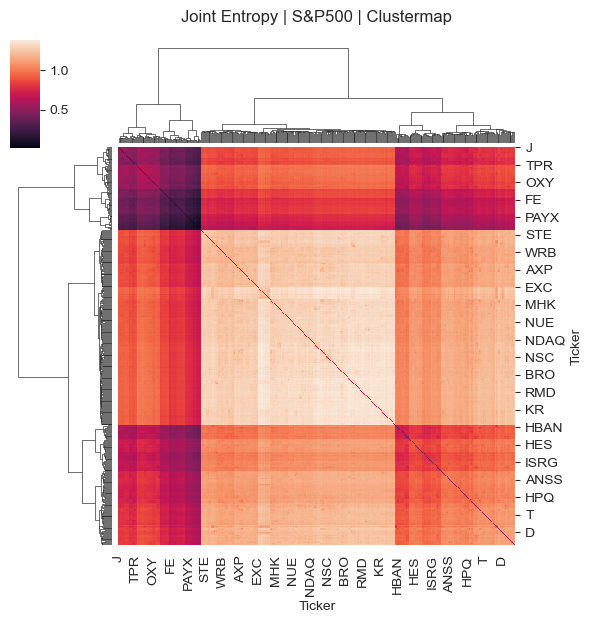

In [33]:
clustermap = sns.clustermap(joint_df.astype(float), annot = False, figsize = (6, 6))
clustermap.ax_heatmap.set_title('Joint Entropy | S&P500 | Clustermap', pad = 90)
#plt.tight_layout()
plt.show()

### Conditional Entropy

$Y$가 주어졌을 때 $X$의 조건부 엔트로피는 다음과 같이 정의된다.

$$H(X|Y) = H(X, Y) - H(Y) = -\sum_{y \in S_Y} p(y) \sum_{x \in S_X}p(x|Y = y)\log(p(x | Y = y))$$

여기서 $p(x | Y = y)$는 $Y$가 $y$값을 취할 때 조건부로 $X$가 $x$값을 취하는 확률이다. 이 정의를 따라서 $H(X|Y)$는 $Y$의 값을 들었을 때 $X$에서 기대하는 불확실성이다. 따라서 $H(X|Y) = 0$이고, $H(X) \geq H(X|Y)$이다.

### Kullback Leibler Divergence

$p$와 $q$가 동일한 확률 공간에 정의된 2개의 이산 확률 분포라 하자. $p$와 $q$간의 Kullback Leibler Divergence는 다음과 같다.

$$D_{KL}\left[p \Vert q\right] = - \sum_{x \in S_X} p(x) \log \left( \frac{q(x)}{p(x)}\right)
= \sum_{x \in S_X} p(x)\log \left( \frac{p(x)}{q(x)}\right)
$$

여기서 $q(x) = 0 \Rightarrow p(x) = 0$이다. 직관적으로 이 표현은 $p$가 얼마나 기준 분포 $q$로부터 발산하는가를 측정한다. KL발산은 거리 척도가 아니다. 항상 비음이지만, 대칭성 $D_{KL}\left[p \Vert q\right] \leq 0$과 삼각 부등 조건 $\left( D_{KL}\left[p \Vert q\right] \neq D_{KL}\left[q \Vert p\right]\right)$을 위배한다. 두 랜덤 변수가 반드시 동일한 확률 공간에 존재할 필요가 없는 결합 엔트로피의 정의와의 차이를 주목하자. KL발산은 변분 추론에 널리 사용된다.

### Cross Entropy

$p$와 $q$를 동일한 확률 공간에 정의된 2개의 이산 확률 분포라 하자. $p$와 $q$간의 교차 엔트로피는 다음과 같다.

$$H_C\left[ p \Vert q\right] = - \sum_{x \in S_X} p(x) \log(q(x)) = H(X) + D_{KL}(p \Vert q)$$

교차 엔트로피는 진정한 분포 $p$가 아닌 잘못된 분포 $q$를 사용해서 정보 내용을 평가할 때의 $X$와 연관된 불확실성으로 해석될 수 있다. 교차 엔트로피는 분류 문제에 있어서 인기 높은 점수 함수이며, 특히 금융 응용에 유용하다.

### Mutual Information

Mutual Information은 $Y$값을 알 때 초래되는 $X$의 불확실성 감소로 정의된다. 

$$
\begin{align}
I(X,Y) &= H(X) - H(X|Y) \\
       &= H(X) + H(Y) - H(X, Y) \\
       &= \sum_{x \in S_X} \sum_{y \in S_Y} p(x,y)\log \left( \frac{p(x,y)}{p(x)p(y)}\right) \\
       &= D_{KL}\left[ p(x,y) \Vert p(x)p(y)\right] = \sum_{y \in S_Y} p(y) \sum_{x \in S_X} p(x|y) \log \left( \frac{p(x|y)}{p(x)}\right) \\
       &= E_Y \left[ D_{KL}\left[ p(x|y) \Vert p(x)\right] \right] = \sum_{x \in S_X} p(x) \sum_{y \in S_Y} p(x|y) \log \left( \frac{p(y|x)}{p(y)}\right) \\
       &= E_X \left[ D_{KL}\left[ p(y|x) \Vert p(y)\right] \right]
\end{align}
$$

위에서 $I(X,Y) \geq 0, I(X,Y) = I(Y,X)$이고, $I(X, X) = H(X)$임을 알 수 있다. $X$와 $Y$가 독립일 때 $p(x, y) = p(x)p(y)$이므로 $I(X, Y) = 0$이다. 상계는 $I(X, Y) \leq \min \{H(X), H(Y)\}$로 주어진다. 그러나 상호 정보는 거리 척도가 아니다. 왜냐하면 이는 삼각 부등식 $I(X,Z) \nleq I(X,Y) + I(Y, Z)$을 성립하지 못하기 때문이다. 상호 정보의 중요한 속성은 다음의 그룹화 특성이다.

$$I(X, Y, Z) = I(X, Y) + I\left[(X, Y), Z\right]$$

여기서 $(X, Y)$는 $X$와 $Y$의 결합 분포를 나타낸다. $X, Y$와 $Z$는 그 자체로 결합 분포를 나타낼 수 있기 때문에 위의 특성은 상호 정보를 더 단순한 구성 요소로 분해하는 데 사용할 수 있다. 이는 상호 정보를 응집형 군집화 알고리즘과 전방 특성 선택의 맥락에서 유용한 유사도 척도로 만든다.

차원당 일정 수의 분할을 가진 정규화된 그리드로 이산화된 동일 크기의 2개의 배열 $x$와 $y$가 주어졌을 때 아래의 코드는 한계 엔트로피, 결합 엔트로피, 조건부 엔트로피와 상호 정보를 계산하는 법을 보여준다.

In [34]:
from FinancialMachineLearning.metrics.distance import mutual_information

mi = mutual_information(ret)

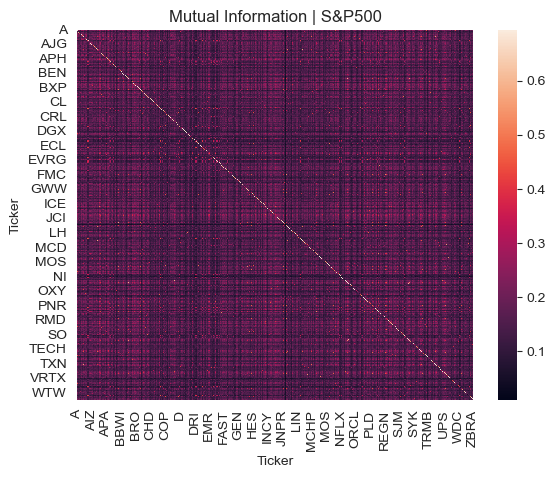

In [35]:
sns.heatmap(mi)
plt.title('Mutual Information | S&P500')
plt.show()

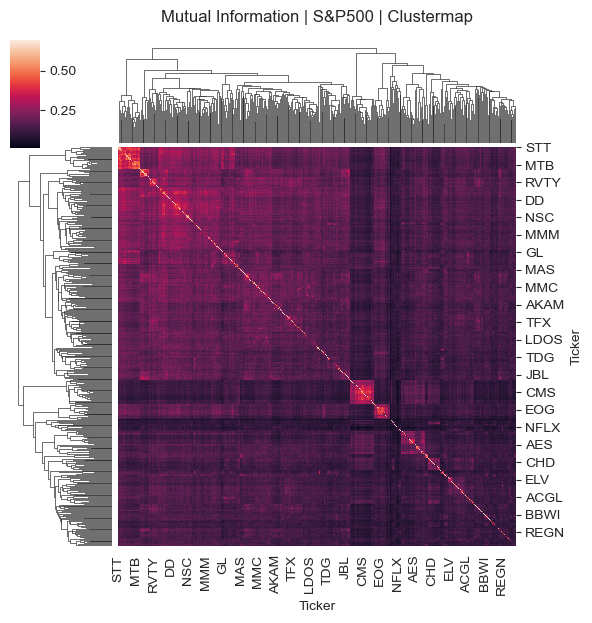

In [36]:
clustermap = sns.clustermap(mi, annot = False, figsize = (6, 6))
clustermap.ax_heatmap.set_title('Mutual Information | S&P500 | Clustermap', pad = 90)
#plt.tight_layout()
plt.show()

### Variational Information

정보 변분은 다음과 같이 정의된다

$$
\begin{align}
VI(X,Y) &= H(X|Y) + H(Y|X) \\
    &= H(X) + H(Y) - 2I(X,Y) \\
    &= 2H(X,Y) - H(X) - H(Y) \\
    &= H(X, Y) - I(X, Y)
\end{align}
$$

이 척도는 다른 변수의 값을 들었을 때 다른 한 변수에서 예상하는 불확실성으로 해석할 수 있다. 이는 $VI(X, Y) = 0 \Leftrightarrow X = Y$와 같은 하계, $VI(X,Y) \leq H(X,Y)$와 같은 상계를 갖는다. 정보 변분은 거리 척도다. 왜냐하면 비음성, 대칭성, 삼각 부등식의 공리를 만족하기 때문이다.

$H(X, Y)$는 $S_X$와 $S_Y$의 크기의 함수이므로 $VI(X,Y)$는 엄격한 상계를 갖지 않는다. 우리는 여러 모집단 크기 간에 정보 변분을 비교하고자 하기 때문에 이것은 문제가 된다. 다음 식은 모든 $(X,y)$쌍에 대해 0과 1 사이로 한정되는 척도다

$$\tilde{VI}(X,Y) = \frac{VI(X,Y)}{H(X,Y)} = 1 - \frac{I(X,Y)}{H(X,Y)}$$

Kraskov(2008)을 따라서 더 강한 대안의 한정된 척도는 다음과 같다.

$$\tilde{\tilde{VI}}(X,Y) = \frac{\max\{H(X|Y), H(Y|X)\}}{\max\{H(X), H(Y)\}} = 1 - \frac{I(X,Y)}{\max\{H(X), H(Y)\}}$$

여기서 모든 $(X,y)$쌍에 대해 $\tilde{\tilde{VI}}(X,Y) \leq \tilde{VI}(X,Y)$이다. 이전의 예저를 따라서 아래 코드는 정보 변분을 계산한다.

In [37]:
from FinancialMachineLearning.metrics.distance import variational_information

vi = variational_information(ret)

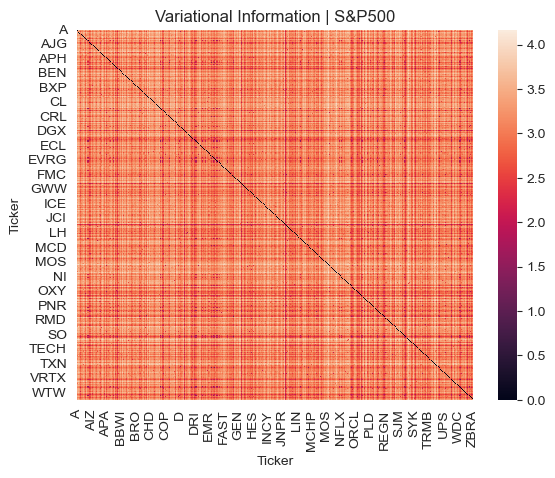

In [38]:
sns.heatmap(vi)
plt.title('Variational Information | S&P500')
plt.show()

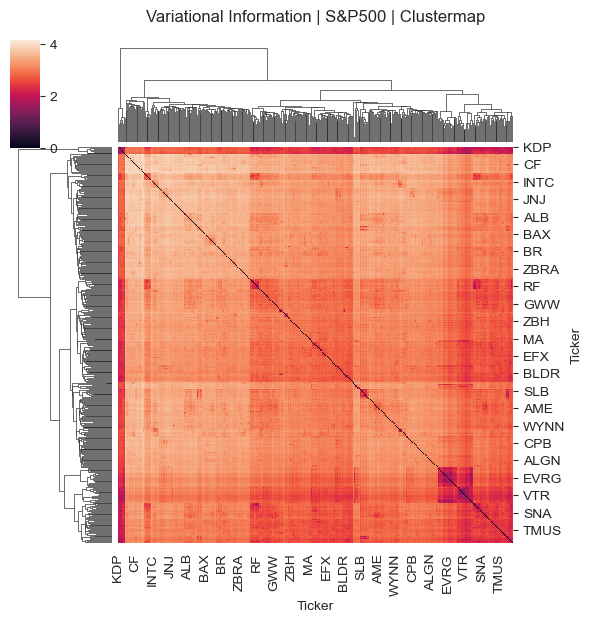

In [39]:
clustermap = sns.clustermap(vi, annot = False, figsize = (6, 6))
clustermap.ax_heatmap.set_title('Variational Information | S&P500 | Clustermap', pad = 90)
plt.show()